In [1]:
import os
import requests
import json
import pandas as pd

In [2]:
from pandasai import PandasAI

from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=os.environ["OPENAI_API_KEY"])

Location: [latitude, longitude]

List Place Type: https://developers.google.com/maps/documentation/places/web-service/supported_types?hl=id

In [3]:
api_key = os.environ["GOOGLE_MAPS_API_KEY"]

location = '-6.89742292289528,109.678618210094'
radius = '1000'

place_type = 'cafe'

In [9]:
url = f'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius={radius}&type={place_type}&business_status=operational&key={api_key}'

response = requests.get(url)
data = json.loads(response.text)

businesses = []

for result in data['results']:
    name = result['name']
    address = result['vicinity']
    latitude = result['geometry']['location']['lat']
    longitude = result['geometry']['location']['lng']
    rating = result.get('rating', 0)
    compound_code = result.get('plus_code', {}).get('compound_code', 'N/A')
    province = compound_code.split(',')[-2].strip() if compound_code != 'N/A' else 'N/A'
    city = compound_code.split(',')[-3].split(' ')[1].strip() if compound_code != 'N/A' else 'N/A'
    categories = ', '.join(result.get('types', []))

    businesses.append({
        'name': name,
        'province': province,
        'city': city,
        'address': address,
        'latitude': latitude,
        'longitude': longitude,
        'categories': categories,
        'rating': rating,
    })

df = pd.DataFrame(businesses, columns=['name', 'province', 'city', 'address', 'latitude', 'longitude', 'categories', 'rating'])

In [10]:
df_1 = _deepnote_execute_sql('SELECT * FROM df', 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

,name,province,city,address,latitude,longitude,categories,rating
0,Teh Tong TJI,Central Java,Pekalongan,"L1 , Plaza Pekalongan , JL. Nusantara No. 05 ,...",-6.897833,109.678888,"cafe, point_of_interest, food, establishment",5.0
1,Corleoné by Hoody,Central Java,Pekalongan,"Jalan Cempaka No.86a, Poncol",-6.888896,109.679621,"restaurant, cafe, point_of_interest, food, est...",4.6
2,Cava milkshake,Central Java,Pekalongan,"Jalan R.A. Kartini No.40, RW.6, Keputran",-6.897344,109.678499,"cafe, point_of_interest, food, establishment",0.0
3,Angkringan gondrong,Central Java,Pekalongan,"Jalan R.A. Kartini No.40, RW.6, Keputran",-6.897316,109.678493,"cafe, point_of_interest, food, establishment",0.0
4,Angkringan Memet,Central Java,Pekalongan,"Jalan R.A. Kartini No.40, RW.6, Keputran",-6.897316,109.678493,"cafe, point_of_interest, food, establishment",5.0
5,Seblak food sundanese,Central Java,Pekalongan,"Jalan R.A. Kartini No.40, Keputran",-6.897264,109.678521,"cafe, point_of_interest, food, establishment",4.0
6,brabuuz,N/A,N/A,"4M3H+48J, Jalan R.A. Kartini, Keputran",-6.897159,109.678269,"cafe, point_of_interest, food, establishment",0.0
7,HOBI4D cafe,N/A,N/A,"4M2H+VJF, Noyontaan",-6.897801,109.679060,"cafe, point_of_interest, food, establishment",0.0
8,Pak Herman Coffee and Guyon,N/A,N/A,"4M2H+XM9, Noyontaan",-6.897581,109.679227,"cafe, point_of_interest, food, establishment",4.7
9,A&S Coffee,N/A,N/A,"4M2H+QHC, Jalan R.A. Kartini, Noyontaan",-6.898061,109.678906,"cafe, point_of_interest, food, establishment",5.0


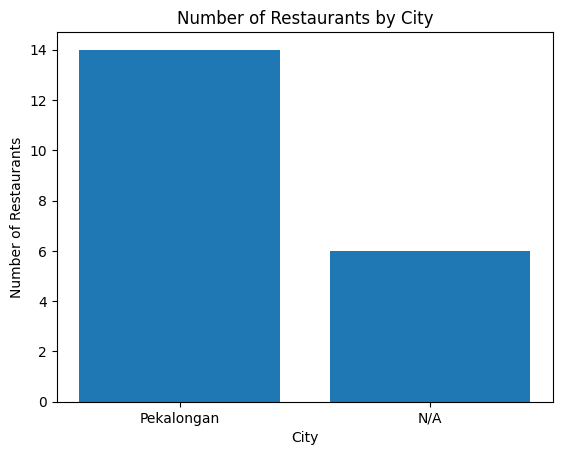

'Sure, let me help you come up with a good plot based on the data you have.'

In [11]:
pandas_ai = PandasAI(llm)
pandas_ai.run(df, prompt='Try to create a good plot from this data')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa0ff5c2-b244-406d-b1f4-a2f4cd653e27' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>